In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')
import cv2 as cv
import matplotlib.gridspec as gridspec
import os
from tqdm import tqdm
from RemoveBlackEdge import remove_black_edge

In [2]:
# set up the good_point_limited
GOOD_POINTS_LIMITED = 0.99

In [3]:
feature_extraction_algo = 'orb'

feature_to_match = 'bf'

In [7]:
# read images
path = 'images'
input_path = path + '/input/'
output_path = path + '/output/'
filenames = [input_path + filename for filename in os.listdir(input_path)]
raw_images = [cv.imread(filename) for filename in filenames]

# OpenCV defines the color channel in the order BGR 
# Hence converting to RGB for Matplotlib
raw_images_rgb = [cv2.cvtColor(raw_images,cv2.COLOR_BGR2RGB) for raw_images in raw_images]
# converting to grayscale
raw_images_gray = [cv2.cvtColor(raw_images_rgb, cv2.COLOR_RGB2GRAY) for raw_images_rgb in raw_images_rgb  ]


count = len(raw_images)



In [8]:
# reset the order of the images
# to make the center one is the source image
# and extend to both sides
images = []
new_idx = (count - 1) // 2
k = -1
for i in range(count):
    new_idx = new_idx + k * i
    images.append(raw_images[new_idx])
    k *= -1


# initialize the source image
img_src = images[0]


100%|██████████| 3/3 [05:48<00:00, 116.33s/it]


True

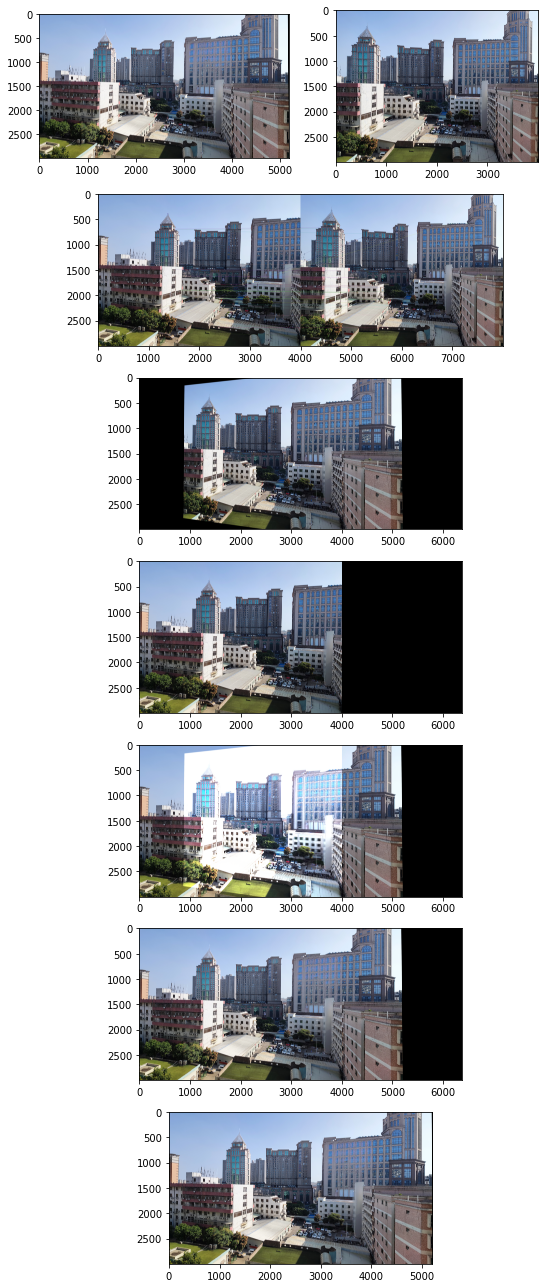

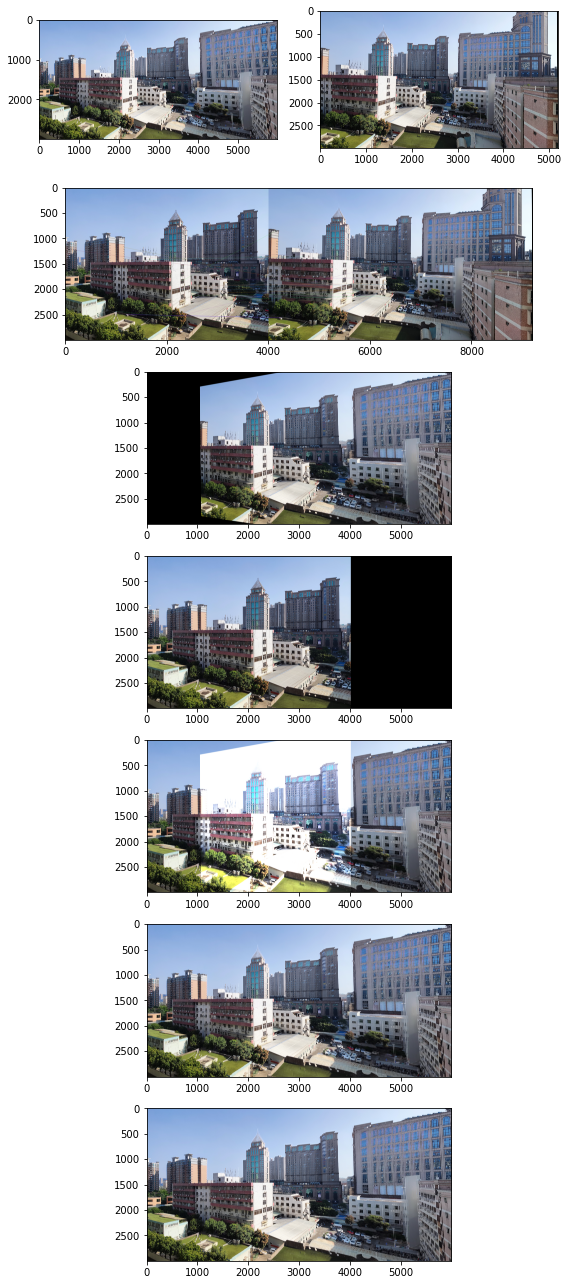

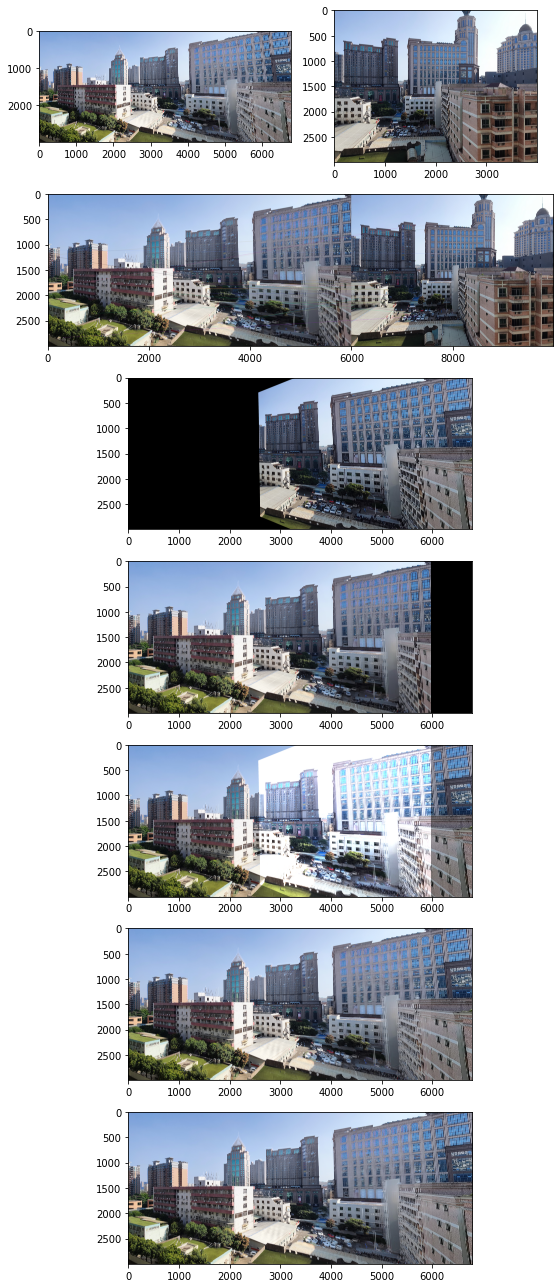

In [9]:

# the image need to stitch
for i in tqdm(range(1, len(images))):
    img_dst = images[i]
    # make sure to merge from left to right
    if i % 2 == 0:
        img_src, img_dst = img_dst, img_src

    # detects keypoints and computes the descriptors
    def select_descriptor_methods(image, method=None):    
    
        assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift', 'surf'"

        if method == 'sift':
            descriptor = cv2.SIFT_create()
        elif method == 'surf':
            descriptor = cv2.SURF_create()
        elif method == 'brisk':
            descriptor = cv2.BRISK_create()
        elif method == 'orb':
            descriptor = cv2.ORB_create()

        (keypoints, features) = descriptor.detectAndCompute(image, None)

        return (keypoints, features)

    kp1, des1 = select_descriptor_methods(img_src, method=feature_extraction_algo)
    kp2, des2 = select_descriptor_methods(img_dst, method=feature_extraction_algo)
    
    # set up the BFMatcher
    bf = cv.BFMatcher_create()
    matches = bf.match(des1, des2)
    # sorted by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # pick up the good keypoints
    good_points = []
    for j in range(len(matches) - 1):
        if matches[j].distance < GOOD_POINTS_LIMITED * matches[j + 1].distance:
            good_points.append(matches[j])

    # show the good keypoints
    img_matches = cv.drawMatches(img_src, kp1, img_dst, kp2, good_points, None)

    # the index of the keypoints and descriptors
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)

    # generate transformation matrix
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RHO)

    # get the height and width of the original images
    h1, w1, p1 = img_src.shape
    h2, w2, p2 = img_dst.shape
    h = np.maximum(h1, h2)
    w = np.maximum(w1, w2)

    move_dis = int(np.maximum(dst_pts[0][0][0], src_pts[0][0][0]))
    img_transform = cv.warpPerspective(img_dst, M, (w1 + w2 - move_dis, h))

    M1 = np.float32([[1, 0, 0], [0, 1, 0]])
    dst1 = cv.warpAffine(img_src, M1, (w1 + w2 - move_dis, h))

    dst = cv.add(dst1, img_transform)

    dst_target = np.maximum(dst1, img_transform)

    # remove black edge
    dst_target_removed = remove_black_edge(dst_target)

    # use dst_target as the source image
    img_src = dst_target_removed

    # show all images
    fig = plt.figure(tight_layout=True, figsize=(8, 18))
    gs = gridspec.GridSpec(7, 2)

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(img_src[:, :, ::-1])

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(img_dst[:, :, ::-1])

    ax = fig.add_subplot(gs[1, :])
    ax.imshow(img_matches[:, :, ::-1])

    ax = fig.add_subplot(gs[2, :])
    ax.imshow(img_transform[:, :, ::-1])

    ax = fig.add_subplot(gs[3, :])
    ax.imshow(dst1[:, :, ::-1])

    ax = fig.add_subplot(gs[4, :])
    ax.imshow(dst[:, :, ::-1])

    ax = fig.add_subplot(gs[5, :])
    ax.imshow(dst_target[:, :, ::-1])

    ax = fig.add_subplot(gs[6, :])
    ax.imshow(dst_target_removed[:, :, ::-1])

    plt.savefig(output_path + 'panorama_processing_{}.jpg'.format(i))

cv.imwrite(output_path + 'panorama.jpg', img_src)